In [2]:
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as md

from itertools import count
from collections import Counter
import matplotlib

from nltk.tokenize import RegexpTokenizer


from time import mktime
from datetime import datetime
from datetime import timedelta


In [3]:
import sys

def parse(f,chunksize = 100000, cols = None, test_bool = False, dtype = None):
    lines = 9041*1000
    for i,gm_chunk in enumerate(pd.read_csv("../ira_tweets_csv_hashed.csv",chunksize = chunksize, usecols = cols, dtype = dtype)):
        f(gm_chunk)
        if test_bool:
            print('Done')
            break
        j = i*chunksize/lines
        sys.stdout.write('\r')
        # the exact output you're looking for:
        bar_int = int(j*20+1)
        sys.stdout.write("[%-20s] %d%%" % ('='*bar_int, int(j*100+1)))
        sys.stdout.flush()

In [4]:
global df_test
def f(chunk):
    global df_test
    df_test = chunk

parse(f, 2, test_bool = True)

df_test[:1].to_string()

Done


'              tweetid                                             userid                                  user_display_name                                   user_screen_name user_reported_location user_profile_description  user_profile_url  follower_count  following_count account_creation_date account_language tweet_language                                         tweet_text        tweet_time tweet_client_name  in_reply_to_tweetid  in_reply_to_userid  quoted_tweet_tweetid  is_retweet  retweet_userid  retweet_tweetid  latitude  longitude  quote_count  reply_count  like_count  retweet_count hashtags                                          urls user_mentions  poll_choices\n0  877919995476496385  249064136b1c5cb00a705316ab73dd9b53785748ab757f...  249064136b1c5cb00a705316ab73dd9b53785748ab757f...  249064136b1c5cb00a705316ab73dd9b53785748ab757f...         Москва, Россия    Я примерный семьянин!               NaN             132              120            2013-12-07               ru      

# Sentiment Analysis

In [6]:
#import the dataset
df_labmt = pd.read_csv("Data_Set_S1.txt", delimiter = '\t', header = 2)

In [7]:
#create a dictionary with the words as keys
#and their happiness_average as values
havg_w = {w:v for w,v in zip(df_labmt['word'], df_labmt['happiness_average'])}

In [8]:
#function that returns the sentiment of a wordlist
#if the wordlist is empty, than it will return
#the type np.nan, which than wont be incorporated for calculating the mean

#SENTIMENTS
def h_avg(wordlist):
    if len(wordlist) == 0:
        return np.nan
    else:
      #np.nanmean calculates the mean without incorporating np.nan
        return np.nanmean([havg_w.get(w, np.nan) for w in wordlist])

In [11]:
num_lines = 0

def f(chunk):
    global num_lines
    num_lines = num_lines + len(chunk)
    
parse(f, 1000000, test_bool = False)
num_lines

[====================] 100%

9041308

In [220]:
cols = ['tweet_language', 'account_language']

langs = set()

def f(chunk):
    global langs
    for t,a in zip(chunk['tweet_language'], chunk['account_language']):
        langs.add(t)
        langs.add(a)
        
parse(f, 1000000, cols = cols, test_bool = False)

[====================] 100%

# creating large array 'sents' with all important data

(including sentiments of tweets and profile desciption)

In [225]:
langs_dict = {l:i for i,l in enumerate(list(langs))}

In [231]:
min_times = datetime(2009, 5, 9, 15, 59)
min_times

datetime.datetime(2009, 5, 9, 15, 59)

In [243]:
tokenizer = RegexpTokenizer(r'\w+')

to_date_time = lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M')


cols = ['tweet_text', 'tweet_language', 'like_count', 'retweet_count', 'quote_count', 'reply_count', 'account_language', 'user_profile_description', 'tweet_time', 'follower_count']

k = 0

sents = np.zeros((num_lines + 1, 12))
#tweets = []


def f(chunk):
    global k
    global sents
    
    for t,lang,content,likes,retw,quotes,replys,ac_lang,desc, fol_count in zip(chunk['tweet_time'],chunk['tweet_language'], chunk['tweet_text'], chunk['like_count'], chunk['retweet_count'], chunk['quote_count'], chunk['reply_count'], chunk['account_language'], chunk['user_profile_description'], chunk['follower_count']):
        k = k + 1
        sents[k,0] = (to_date_time(t) - min_times).days
        sents[k,1] = langs_dict[lang]
        if type(content) != float and len(content) > 0:
            words = [w.lower() for w in tokenizer.tokenize(content)]
            sents[k,2] = len(words)
            sents[k,3] = h_avg(words)
            
        sents[k,4] = likes
        sents[k,5] = retw
        sents[k,6] = quotes
        sents[k,7] = replys
            
        sents[k,8] = langs_dict[ac_lang]
        if type(desc) != float and len(desc) > 0:
            words = [w.lower() for w in tokenizer.tokenize(desc)]
            sents[k,9] = h_avg(words)
            sents[k,10] = len(words)
        
        sents[k,11] = fol_count
            
        

        
        #tweets.extend([content])

parse(f, 50000, cols = cols, test_bool = False)

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


[====================] 100%

## save this array

In [248]:
np.save("tweet_sentiments.npy", sents)

In [5]:
sents = np.load('tweet_sentiments.npy')

In [21]:
def clean_nan_zeros(raw):
    clean = raw[~np.isnan(raw)]
    clean = clean[clean != 0]
    return clean

In [22]:
def clean_sents(raw_sents):
    cleaned_sents = clean_nan_zeros(raw_sents)
    cleaned_sents = cleaned_sents[cleaned_sents < 10]
    return cleaned_sents

In [252]:
tw_sents = clean_sents(sents[:,3])
desc_sents = clean_sents(sents[:,9])

In [295]:
len(tw_sents), len(desc_sents)

(7864581, 3686054)

In [256]:
np.average(tw_sents), np.std(tw_sents)

(5.196943870758352, 0.33854862686533915)

In [257]:
np.average(desc_sents), np.std(desc_sents)

(5.544027008321617, 0.6291511879991792)

(array([1.740000e+02, 6.260000e+02, 2.316000e+03, 2.023000e+04,
        2.233883e+06, 4.827472e+06, 7.248780e+05, 4.539800e+04,
        8.556000e+03, 1.048000e+03]),
 array([1.3 , 2.02, 2.74, 3.46, 4.18, 4.9 , 5.62, 6.34, 7.06, 7.78, 8.5 ]),
 <a list of 10 Patch objects>)

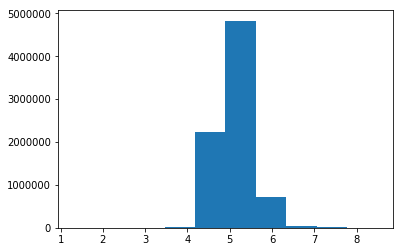

In [253]:
plt.hist(tw_sents)

(array([   7164.,    8885.,  120074.,  435069., 1201878., 1533166.,
         209973.,   65942.,   90430.,   13473.]),
 array([2.75 , 3.317, 3.884, 4.451, 5.018, 5.585, 6.152, 6.719, 7.286,
        7.853, 8.42 ]),
 <a list of 10 Patch objects>)

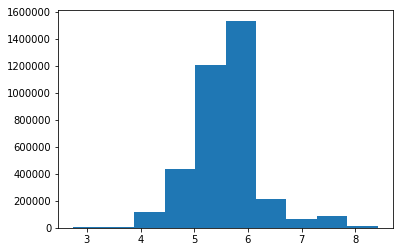

In [254]:
plt.hist(desc_sents)

In [288]:
#bins = np.linspace(0,10,1000)
tw_hist, tw_bins = np.histogram(tw_sents, bins = np.linspace(0.01,10, 500))
desc_hist, desc_bins = np.histogram(desc_sents, bins = np.linspace(0.01,10,100))

(0, 500000.0)

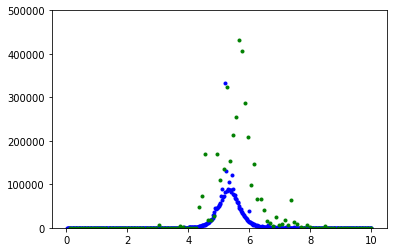

In [289]:
plt.plot(tw_bins[1:], tw_hist, '.', color = 'blue')
plt.plot(desc_bins[1:], desc_hist, '.', color = 'green' )
plt.ylim((0,0.5e6))

# Comparing sentiments of tweets (blue) and profiles (green)

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


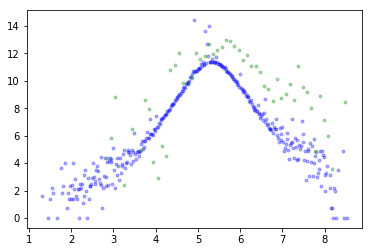

In [294]:
plt.plot(tw_bins[1:], np.log(tw_hist), '.', color = 'blue', alpha = 0.3)
plt.plot(desc_bins[1:], np.log(desc_hist), '.', color = 'green', alpha = 0.3)

# Heatmap: tweet-Sentiments to profile description sentiments

In [6]:
raw_tw_sents = sents[:,3]
raw_desc_sents = sents[:,9]

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


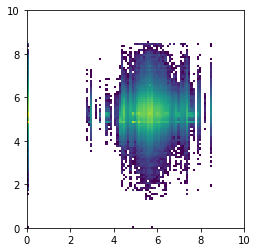

In [33]:
bins_x = np.linspace(0,10, 100)
bins_y = np.linspace(0,10,1000)

bins = np.meshgrid(bins_x, bins_y)
heatmap, xedges, yedges = np.histogram2d(raw_desc_sents, raw_tw_sents, bins=[100,100], range = [[0, 10], [0, 10]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(np.log(heatmap).T, extent=extent, origin='lower')

plt.savefig('tw_ents-desc_sents.png', dpi = 300)
plt.show()

# Like distribution according to sentiments

## Like distribution

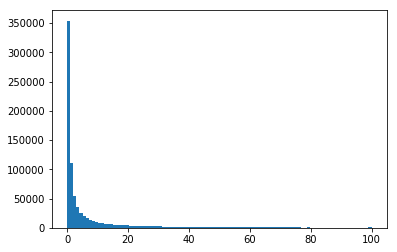

In [34]:
a = plt.hist(clean_nan_zeros(sents[:,4]), bins = np.linspace(0,100, 100))

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


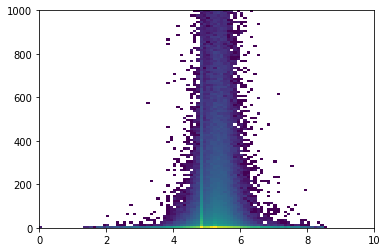

In [36]:
bins_x = np.linspace(0,10, 100)
bins_y = np.linspace(0,10,1000)

heatmap, xedges, yedges = np.histogram2d(raw_tw_sents, sents[:,4], bins=[100,100], range = [[0, 10], [0, 1000]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(np.log(heatmap).T, extent=extent, origin='lower')
plt.axis('auto')

plt.savefig('sent-like-dist.png', dpi = 300)
plt.show()

In [52]:
likes_avg_sents = [np.average(heatmap[i]) for i in range(len(heatmap))]

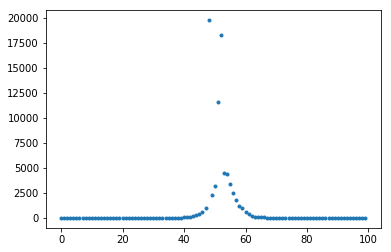

In [55]:
plt.plot(likes_avg_sents, '.')

In [209]:
hist2,bins2 = np.histogram(sents_over2, bins = np.linspace(0,10,100))

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


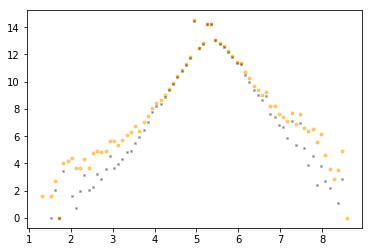

In [210]:
plt.plot(bins[1:], np.log(hist), '.', alpha = 0.5, color = 'orange')
plt.plot(bins2[1:], np.log(hist2), 'x', color = 'black', ms = 2, alpha = 0.5)

In [189]:
a_hist = np.argsort(hist)
hist[a_hist[::-1]], bins[a_hist[::-1]]

(array([1106999,  901300,  784336, ...,       0,       0,       0]),
 array([5.25252525, 4.88948895, 5.15951595, ..., 7.88278828, 7.88378838,
        0.        ]))

In [195]:
np.average(cleaned_sents)

5.196943870758352

In [191]:
np.histogram(sents[:,0], bins = [0,10,100,1e17])

(array([296107,      0,      0]), array([0.e+00, 1.e+01, 1.e+02, 1.e+17]))

In [115]:
h_avg(["hi", "this", "is", "jöaldfj", "no"])

5.115